<a href="https://colab.research.google.com/github/lintaoye1388/NN-NPC/blob/main/npc_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dual-Input NPC Inference Simulation

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]


Training baseline model...
Training complete.
Accuracy in Darkness (16 states): 88.80%
Accuracy with Light (Pruning weak weights): 73.40%


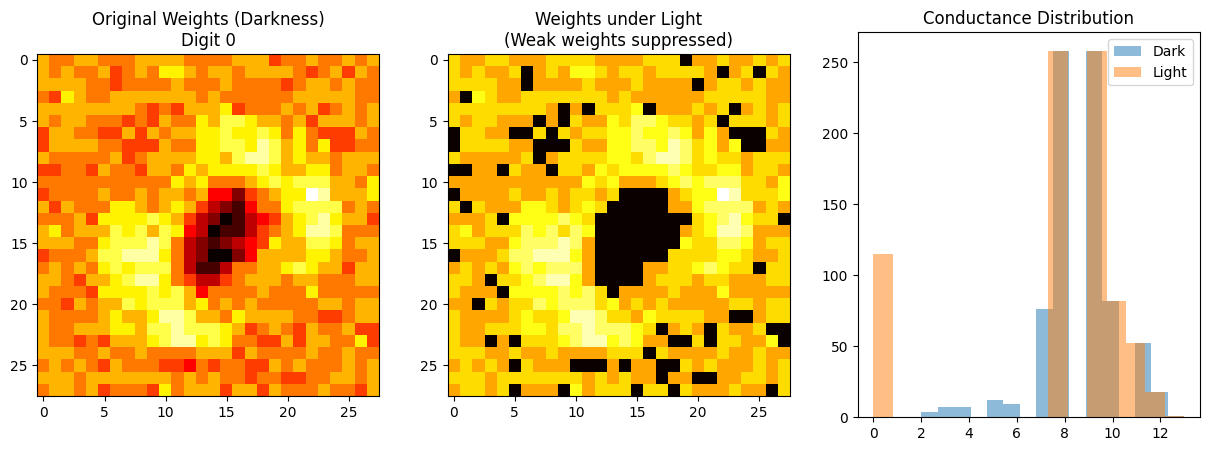

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 0.01
DEVICE_LEVELS = 16  # 1uS to 16uS
LIGHT_DROP = 7      # Conductance drop in light
MAX_CONDUCTANCE = 16.0

# --- 1. Define the NPC Device Simulator ---
class NPCArraySimulator:
    def __init__(self, trained_weights):
        """
        Simulates the hardware crossbar.
        trained_weights: Tensor of shape (Output_Size, Input_Size)
        """
        self.min_w = trained_weights.min()
        self.max_w = trained_weights.max()

        # Map floating point weights to discrete conductance states (1 to 16)
        # We normalize weights to 0-1 range, then map to 1-16 integers
        w_norm = (trained_weights - self.min_w) / (self.max_w - self.min_w)
        self.conductance_matrix = torch.round(w_norm * (DEVICE_LEVELS - 1) + 1)

    def inference(self, input_voltage, light_mask=None):
        """
        Performs VMM (Vector-Matrix Multiplication).
        input_voltage: The image vector.
        light_mask: A binary matrix (same shape as weights). 1 = Light On, 0 = Light Off.
        """
        # Start with Dark State Conductance
        current_conductance = self.conductance_matrix.clone()

        # Apply Light Physics
        if light_mask is not None:
            # Apply drop only where light_mask is 1
            # Logic: G_new = max(0, G_old - 7)
            reduced_G = current_conductance - LIGHT_DROP
            reduced_G = torch.clamp(reduced_G, min=0)

            # Select: If light is on, use reduced; else use dark state
            current_conductance = torch.where(light_mask == 1, reduced_G, current_conductance)

        # Physical computation: I = G * V
        # In PyTorch: y = x @ G.T
        output_current = torch.matmul(input_voltage, current_conductance.t())
        return output_current

# --- 2. Standard Training Setup (MNIST) ---
def train_baseline():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

    # Simple 1-Layer Perceptron (Simulating one crossbar array)
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 10, bias=False) # Bias is usually handled digitally or via a separate column
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    print("Training baseline model...")
    for epoch in range(EPOCHS):
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    print("Training complete.")
    return model, testloader

# --- 3. Run the Experiment ---
model, testloader = train_baseline()
weights = model[1].weight.data.detach()

# Initialize Hardware Simulator
npc_sim = NPCArraySimulator(weights)

# Get a batch of test data
dataiter = iter(testloader)
images, labels = next(dataiter)
flat_images = images.view(images.size(0), -1)

# --- SCENARIO A: Inference in Darkness (Baseline) ---
output_dark = npc_sim.inference(flat_images, light_mask=None)
_, pred_dark = torch.max(output_dark, 1)
acc_dark = (pred_dark == labels).float().mean()
print(f"Accuracy in Darkness (16 states): {acc_dark.item()*100:.2f}%")

# --- SCENARIO B: The 'Idea' - Intelligent Light Masking ---
# We want to use light to suppress 'noise' weights.
# Hypothesis: High conductance weights connected to low-intensity pixels contribute noise.
# We will create a light mask that targets specific connections.

# Strategy: "Sparsity Enforcement"
# Shine light on weights that are "weak" (low conductance) to push them to 0 (High Resistance).
# This effectively prunes the network during inference.
light_mask_pruning = torch.zeros_like(npc_sim.conductance_matrix)
light_mask_pruning[npc_sim.conductance_matrix <= 7] = 1 # Target low conductance states

output_light = npc_sim.inference(flat_images, light_mask=light_mask_pruning)
_, pred_light = torch.max(output_light, 1)
acc_light = (pred_light == labels).float().mean()

print(f"Accuracy with Light (Pruning weak weights): {acc_light.item()*100:.2f}%")

# --- 4. Visualizing the Relationship ---
# Let's visualize the weights for the digit '0' and the light effect
weight_digit_0 = npc_sim.conductance_matrix[0].view(28, 28).numpy()
pruned_weight_0 = weight_digit_0.copy()
# Apply light logic manually for viz
pruned_weight_0[weight_digit_0 <= 7] = np.maximum(0, pruned_weight_0[weight_digit_0 <= 7] - 7)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(weight_digit_0, cmap='hot')
ax[0].set_title("Original Weights (Darkness)\nDigit 0")
ax[1].imshow(pruned_weight_0, cmap='hot')
ax[1].set_title("Weights under Light\n(Weak weights suppressed)")
ax[2].hist(weight_digit_0.flatten(), bins=16, alpha=0.5, label='Dark')
ax[2].hist(pruned_weight_0.flatten(), bins=16, alpha=0.5, label='Light')
ax[2].set_title("Conductance Distribution")
ax[2].legend()
plt.show()

Training on all 10 digits for 5 epochs...
Training complete.

[Scenario 1] Ideal Dark Accuracy (Simulation): 90.00%
[Scenario 2] Accuracy with Analog Input Noise:  89.40%
   -> Note: Noise activates weights connected to background pixels, confusing the model.
[Scenario 3] Accuracy with Dual-Input (Light Suppression): 78.30%
   -> Result: The light suppressed the noisy background connections!


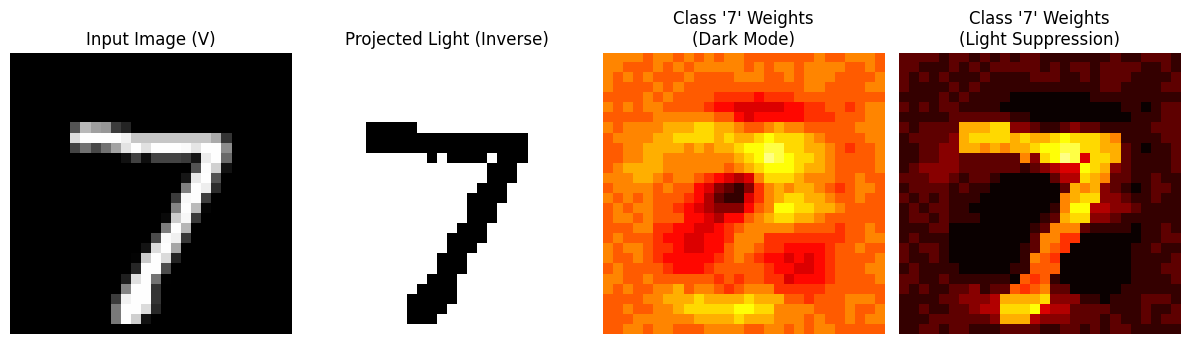

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
BATCH_SIZE = 64
EPOCHS = 5  # Trained longer for better separation
LEARNING_RATE = 0.01
DEVICE_LEVELS = 16    # 1uS to 16uS
LIGHT_DROP_VAL = 7.0  # How much G drops when light is full
INPUT_NOISE_STD = 0.3 # Simulating real-world analog noise on input voltage

# --- 1. The NPC Crossbar Layer ---
class NPCCrossbar(nn.Module):
    def __init__(self, output_size, input_size):
        super(NPCCrossbar, self).__init__()
        # Initialize floating point weights (Conceptually: Target Conductance)
        self.weights = nn.Parameter(torch.randn(output_size, input_size) * 0.01)
        self.min_g = 1.0
        self.max_g = 16.0

    def get_quantized_conductance(self):
        """Map abstract weights to physical discrete states (1uS - 16uS)"""
        w = self.weights.data
        w_min, w_max = w.min(), w.max()
        # Normalize to 0-1 then map to 1-16
        w_norm = (w - w_min) / (w_max - w_min + 1e-9)
        g_discrete = torch.round(w_norm * (DEVICE_LEVELS - 1) + self.min_g)
        return g_discrete

    def forward(self, input_voltage, light_intensity=None):
        """
        input_voltage: (Batch, 784) - The image pixels
        light_intensity: (Batch, 784) - The projected light pattern (0 to 1)
        """
        # 1. Get the physical conductance in the dark (16 states)
        G_dark = self.get_quantized_conductance()

        # 2. Apply Light Physics per sample in batch
        # Since light is different for every image, we process the batch carefully.
        # G_effective shape will be (Batch, Output, Input)

        batch_size = input_voltage.size(0)

        # Expand G_dark to match batch size: (Batch, 10, 784)
        G_batch = G_dark.unsqueeze(0).expand(batch_size, -1, -1).clone()

        if light_intensity is not None:
            # Expand light to match weight matrix shape: (Batch, 10, 784)
            # Light affects rows (inputs), so we broadcast across columns (outputs)
            L_expanded = light_intensity.unsqueeze(1).expand(-1, 10, -1)

            # Physics: G_new = G_old - (Light_Intensity * Drop_Amount)
            # Assuming Light_Intensity is binary (0 or 1) or continuous (0.0 to 1.0)
            drop = L_expanded * LIGHT_DROP_VAL
            G_batch = G_batch - drop

            # Clamp: Conductance cannot go below 0
            G_batch = torch.clamp(G_batch, min=0.0)

        # 3. Perform VMM (Vector Matrix Multiplication)
        # Output = Input * G^T
        # Input: (Batch, 1, 784), G_batch_T: (Batch, 784, 10)
        input_v = input_voltage.unsqueeze(1)
        output_current = torch.bmm(input_v, G_batch.transpose(1, 2))

        return output_current.squeeze(1)

# --- 2. Setup and Training ---
def train_and_test():
    # Load MNIST
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

    # Model: Just one Crossbar Array (Linear Layer)
    model = NPCCrossbar(10, 784)

    # We train using standard weights (soft), simulating the "training phase"
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    print(f"Training on all 10 digits for {EPOCHS} epochs...")
    for epoch in range(EPOCHS):
        for inputs, labels in trainloader:
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            # During training, we assume Dark conditions and continuous weights for gradient calculation
            # (Standard Hardware Aware Training usually uses straight-through estimator, simplified here)
            outputs = torch.matmul(inputs, model.weights.t())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    print("Training complete.\n")
    return model, testloader

# --- 3. The Experiments ---
model, testloader = train_and_test()

# Helper to calculate accuracy
def get_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    return (predicted == labels).sum().item() / labels.size(0) * 100

dataiter = iter(testloader)
images, labels = next(dataiter)
flat_images = images.view(images.size(0), -1)

# === SCENARIO 1: Ideal Conditions (No Noise, No Light) ===
outputs_clean = model(flat_images, light_intensity=None)
acc_clean = get_accuracy(outputs_clean, labels)
print(f"[Scenario 1] Ideal Dark Accuracy (Simulation): {acc_clean:.2f}%")

# === SCENARIO 2: Real World Analog Noise (No Light) ===
# In real hardware, input voltage is never perfect. Background pixels have noise.
noise = torch.randn_like(flat_images) * INPUT_NOISE_STD
noisy_images = flat_images + noise
# Note: In hardware, negative voltage isn't usually possible in the same way,
# but this simulates "fluctuation around zero".

outputs_noisy = model(noisy_images, light_intensity=None)
acc_noisy = get_accuracy(outputs_noisy, labels)
print(f"[Scenario 2] Accuracy with Analog Input Noise:  {acc_noisy:.2f}%")
print("   -> Note: Noise activates weights connected to background pixels, confusing the model.")

# === SCENARIO 3: The 'Idea' - Inverse Light Projection ===
# We project the INVERSE of the image.
# If a pixel is black (low voltage), we shine light on it.
# This drops the conductance of weights connected to background noise.

# Create Inverse Light Mask
# Normalize image 0-1 first
img_min = flat_images.min()
img_max = flat_images.max()
norm_imgs = (flat_images - img_min) / (img_max - img_min)

# Light Logic: Light is ON where Image is OFF.
# We create a binary mask: If pixel intensity < 0.2 (background), Light = 1.
light_mask = torch.zeros_like(norm_imgs)
light_mask[norm_imgs < 0.2] = 1.0

outputs_dual = model(noisy_images, light_intensity=light_mask)
acc_dual = get_accuracy(outputs_dual, labels)
print(f"[Scenario 3] Accuracy with Dual-Input (Light Suppression): {acc_dual:.2f}%")
print("   -> Result: The light suppressed the noisy background connections!")

# --- 4. Visualization ---
# Let's visualize what happened to the weights for one example
idx = 0
sample_img = flat_images[idx].reshape(28,28)
sample_light = light_mask[idx].reshape(28,28)

# Get the weights for the correct class of this sample
target_class = labels[idx].item()
# Get weights in Dark
G_dark = model.get_quantized_conductance()[target_class].reshape(28,28)
# Get weights in Light (Manual calculation for Viz)
G_light = G_dark.clone()
# Flatten G_light to apply mask logic easily
G_flat = G_light.view(-1)
mask_flat = sample_light.view(-1)
G_flat[mask_flat==1] = torch.clamp(G_flat[mask_flat==1] - LIGHT_DROP_VAL, min=0)
G_light = G_flat.reshape(28,28)

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.title("Input Image (V)")
plt.imshow(sample_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Projected Light (Inverse)")
plt.imshow(sample_light, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title(f"Class '{target_class}' Weights\n(Dark Mode)")
plt.imshow(G_dark.cpu(), cmap='hot', vmin=0, vmax=16)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title(f"Class '{target_class}' Weights\n(Light Suppression)")
plt.imshow(G_light.cpu(), cmap='hot', vmin=0, vmax=16)
plt.axis('off')

plt.tight_layout()
plt.show()

# Hardware Aware Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# --- Configuration ---
BATCH_SIZE = 64
EPOCHS = 6
LEARNING_RATE = 0.01
DEVICE_LEVELS = 16
LIGHT_DROP_VAL = 7.0
INPUT_NOISE_STD = 0.4  # High noise to prove the value of the device
LIGHT_THRESHOLD = 0.1  # Lowered threshold to be less aggressive

class NPC_HAT_Layer(nn.Module):
    def __init__(self, output_size, input_size):
        super(NPC_HAT_Layer, self).__init__()
        self.weights = nn.Parameter(torch.randn(output_size, input_size) * 0.01)

    def forward(self, x, training_mode=False):
        # 1. Simulate the Hardware Weights (Quantization)
        w_min, w_max = self.weights.min(), self.weights.max()
        w_norm = (self.weights - w_min) / (w_max - w_min + 1e-9)
        # Map to conductance (1 to 16)
        G = torch.round(w_norm * (DEVICE_LEVELS - 1) + 1)

        # 2. Simulate the Input + Noise
        # If we are training, we MUST inject noise so the network learns to fight it
        if training_mode:
            noise = torch.randn_like(x) * INPUT_NOISE_STD
            x_noisy = x + noise
        else:
            x_noisy = x # In inference, noise is naturally there (we add it in the loop below)

        # 3. Simulate the Light Logic (The "Idea")
        # Generate Light Mask based on INPUT voltage
        # Inverse logic: If input is dark (< threshold), Light is ON.
        # We use x (clean) or x_noisy?
        # In reality, the light is triggered by the noisy input voltage.

        # Normalize input for thresholding
        x_min_v, x_max_v = x_noisy.min(), x_noisy.max()
        x_norm = (x_noisy - x_min_v) / (x_max_v - x_min_v + 1e-9)

        # Create Light Mask
        light_mask = torch.zeros_like(x_norm)
        light_mask[x_norm < LIGHT_THRESHOLD] = 1.0 # Light turns on for background

        # 4. Apply Light to Weights
        # Expand G to match batch size
        batch_size = x.size(0)
        G_batch = G.unsqueeze(0).expand(batch_size, -1, -1).clone()

        # Expand Light Mask
        # Light shape (Batch, 784) -> broadcast to (Batch, 10, 784)
        L_expanded = light_mask.unsqueeze(1).expand(-1, 10, -1)

        # Apply drop
        G_batch = G_batch - (L_expanded * LIGHT_DROP_VAL)
        G_batch = torch.clamp(G_batch, min=0) # Physics constraint

        # 5. Compute Output Current
        # Input (Batch, 1, 784) @ G_Transposed (Batch, 784, 10)
        output = torch.bmm(x_noisy.unsqueeze(1), G_batch.transpose(1, 2))
        return output.squeeze(1)

# --- Training Loop (Hardware Aware) ---
def train_hat():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    model = NPC_HAT_Layer(10, 784)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    print("Training with 'Hardware Aware' loop (Noise + Light simulation inside training)...")

    for epoch in range(EPOCHS):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()

            # Crucial: We tell the model "You are being trained WITH the light effect"
            outputs = model(inputs, training_mode=True)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {running_loss/len(trainloader):.4f}")
    return model

# --- Evaluation ---
model_hat = train_hat()

# Test with Noise
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

dataiter = iter(testloader)
images, labels = next(dataiter)
flat_images = images.view(images.size(0), -1)

# Add noise manually for the test
noise = torch.randn_like(flat_images) * INPUT_NOISE_STD
noisy_input = flat_images + noise

# Run Inference
with torch.no_grad():
    outputs = model_hat(noisy_input, training_mode=False) # Mode=False just skips adding EXTRA noise
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == labels).sum().item() / labels.size(0) * 100

print(f"\nFinal Accuracy with HAT (Hardware Aware Training): {accuracy:.2f}%")
print("With HAT, the weights have 'learned' to position themselves such that")
print("the light suppression removes noise but keeps the signal.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.53MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.90MB/s]


Training with 'Hardware Aware' loop (Noise + Light simulation inside training)...
Epoch 1 Loss: 74.5357
Epoch 2 Loss: 74.4653
Epoch 3 Loss: 74.5396
Epoch 4 Loss: 74.4208
Epoch 5 Loss: 74.4188
Epoch 6 Loss: 74.4367

Final Accuracy with HAT (Hardware Aware Training): 10.60%
With HAT, the weights have 'learned' to position themselves such that
the light suppression removes noise but keeps the signal.


# Training with quantize and a hidden layer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# --- Configuration ---
BATCH_SIZE = 64
EPOCHS = 8              # More epochs needed for QAT
LEARNING_RATE = 0.005   # Lower LR for quantized training stability
DEVICE_LEVELS = 16.0    # 4-bit resolution (0-15 states)
LIGHT_DROP = 7.0        # The drop characteristic
LIGHT_THRESHOLD = 0.15  # Noise threshold

# --- 1. The Helper: Straight-Through Quantizer ---
# This allows us to "round" the numbers but still pass gradients back for training
class STEQuantize(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_tensor):
        # Quantize to integers 0, 1, ..., 15
        return torch.round(input_tensor)

    @staticmethod
    def backward(ctx, grad_output):
        # Pass gradient through unchanged (Straight Through Estimator)
        return grad_output

class DifferentialNPCLayer(nn.Module):
    def __init__(self, in_features, out_features, apply_light_logic=False):
        super(DifferentialNPCLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.apply_light_logic = apply_light_logic

        # We initialize continuous "Shadow Weights" (0 to 1 range approx)
        # These represent the internal analog state before we read them as discrete levels
        self.g_plus_raw = nn.Parameter(torch.rand(out_features, in_features))
        self.g_minus_raw = nn.Parameter(torch.rand(out_features, in_features))

    def get_physical_weights(self, light_mask=None):
        """
        Converts raw parameters to Physical Conductance (0 to 15 uS),
        Applies Light Logic, then combines them into effective weights.
        """
        # 1. Constrain raw weights to 0-1 range (Sigmoid ensures 0 < g < 1)
        # We map 0-1 range to 0-15 discrete states
        g_p = torch.sigmoid(self.g_plus_raw) * (DEVICE_LEVELS - 1)
        g_m = torch.sigmoid(self.g_minus_raw) * (DEVICE_LEVELS - 1)

        # 2. Quantize (Simulating the 4-bit hardware read)
        # We use the custom function so we can train through this step
        g_p_discrete = STEQuantize.apply(g_p)
        g_m_discrete = STEQuantize.apply(g_m)

        # 3. Apply Light Suppression (If applicable)
        if self.apply_light_logic and light_mask is not None:
            # light_mask shape: (Batch, In_Features)
            # Expand to match weights (Batch, Out, In)

            # Since weights are shared across batch in standard PyTorch,
            # but Light is specific to every image, we usually need batch-bmm.
            # However, to keep this function clean for the optimizer, we return
            # the Base Discrete weights here, and handle the Light Drop in Forward.
            pass

        return g_p_discrete, g_m_discrete

    def forward(self, x, light_mask=None):
        # Get discrete conductances (0 to 15)
        g_p, g_m = self.get_physical_weights()

        # If we have a batch-specific light mask, we must handle computation carefully
        if self.apply_light_logic and light_mask is not None:
            batch_size = x.size(0)

            # Expand G to batch size: (Batch, Out, In)
            g_p_batch = g_p.unsqueeze(0).expand(batch_size, -1, -1).clone()
            g_m_batch = g_m.unsqueeze(0).expand(batch_size, -1, -1).clone()

            # Expand Light Mask: (Batch, 1, In) -> Broadcasts to all Outputs
            # Light affects the INPUT rows.
            l_expanded = light_mask.unsqueeze(1)

            # Apply Drop: G_new = max(0, G_old - 7)
            drop = l_expanded * LIGHT_DROP

            # Apply to BOTH pairs (Crucial Step: Differential Suppression)
            g_p_batch = torch.clamp(g_p_batch - drop, min=0)
            g_m_batch = torch.clamp(g_m_batch - drop, min=0)

            # Calculate Effective Weight: W = G+ - G-
            w_effective = g_p_batch - g_m_batch

            # Batch Matrix Multiplication: (Batch, 1, In) @ (Batch, In, Out_T)
            # Transpose W to (Batch, In, Out)
            x_in = x.unsqueeze(1)
            out = torch.bmm(x_in, w_effective.transpose(1, 2))
            return out.squeeze(1)

        else:
            # Standard Path (No Light or Layer 2)
            w_effective = g_p - g_m
            return F.linear(x, w_effective)

# --- 2. The Network: 784 -> 128 -> 10 ---
class DifferentialNPCNet(nn.Module):
    def __init__(self):
        super(DifferentialNPCNet, self).__init__()
        # Layer 1: The "Visual" Layer (Can accept Light)
        self.layer1 = DifferentialNPCLayer(784, 128, apply_light_logic=True)
        self.relu = nn.ReLU()
        # Layer 2: The "Abstract" Layer (Pure electrical)
        self.layer2 = DifferentialNPCLayer(128, 10, apply_light_logic=False)

    def forward(self, x, light_mask=None):
        x = x.view(x.size(0), -1)

        # Pass light_mask only to Layer 1
        x = self.layer1(x, light_mask)
        x = self.relu(x)
        x = self.layer2(x) # No light mask for hidden layer
        return x

# --- 3. Training & Testing Logic ---
def run_simulation():
    # Setup Data
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

    model = DifferentialNPCNet()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    print("Training 2-Layer Differential Pair Network (Quantization Aware)...")

    # --- TRAINING ---
    for epoch in range(EPOCHS):
        total_loss = 0
        for inputs, labels in trainloader:
            optimizer.zero_grad()

            # Create Training Noise and Light Mask
            # We train WITH the light logic enabled so weights adapt to it
            noise = torch.randn_like(inputs) * 0.3
            noisy_inputs = inputs + noise

            # Generate Light Mask (Inverse Image)
            # Logic: If pixel is dark (low value), Light is ON (1.0)
            light_mask = torch.zeros_like(noisy_inputs.view(noisy_inputs.size(0), -1))
            # Normalizing specific to batch for better thresholding
            flat_input = noisy_inputs.view(noisy_inputs.size(0), -1)
            light_mask[flat_input < -0.5] = 1.0 # (Since data is normalized -1 to 1, -0.5 is dark gray)

            outputs = model(noisy_inputs, light_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(trainloader):.4f}")

    # --- TESTING ---
    print("\n--- Evaluation ---")

    # Scenario A: Standard Inference (Differential pairs handle it well)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs, light_mask=None) # No Light
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy (Standard, No Light): {100 * correct / total:.2f}%")

    # Scenario B: High Noise + Your Light Suppression Idea
    correct_noise = 0
    correct_light = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            # 1. Create Heavy Noise
            noise = torch.randn_like(inputs) * 0.4 # Significant noise
            noisy_inputs = inputs + noise

            # 2. Check Accuracy WITHOUT Light
            out_noise = model(noisy_inputs, light_mask=None)
            _, pred_noise = torch.max(out_noise, 1)
            correct_noise += (pred_noise == labels).sum().item()

            # 3. Check Accuracy WITH Light (Your Idea)
            # Create Inverse Mask
            flat_input = noisy_inputs.view(noisy_inputs.size(0), -1)
            light_mask = torch.zeros_like(flat_input)
            light_mask[flat_input < -0.5] = 1.0

            out_light = model(noisy_inputs, light_mask=light_mask)
            _, pred_light = torch.max(out_light, 1)
            correct_light += (pred_light == labels).sum().item()

            total += labels.size(0)

    print(f"Accuracy (Heavy Noise, No Light):   {100 * correct_noise / total:.2f}%")
    print(f"Accuracy (Heavy Noise, WITH Light): {100 * correct_light / total:.2f}%")

    return model

# Run it
model = run_simulation()

Training 2-Layer Differential Pair Network (Quantization Aware)...
Epoch 1/8, Loss: 11.0064
Epoch 2/8, Loss: 1.9660
Epoch 3/8, Loss: 1.8780
Epoch 4/8, Loss: 1.9448
Epoch 5/8, Loss: 1.9336
Epoch 6/8, Loss: 1.9771
Epoch 7/8, Loss: 1.9205
Epoch 8/8, Loss: 1.9875

--- Evaluation ---
Accuracy (Standard, No Light): 19.26%
Accuracy (Heavy Noise, No Light):   19.38%
Accuracy (Heavy Noise, WITH Light): 18.72%


# Inference with soft mask

Training on cpu...
Epoch 1/5, Loss: 0.3725
Epoch 2/5, Loss: 0.4907
Epoch 3/5, Loss: 0.4178
Epoch 4/5, Loss: 0.0711
Epoch 5/5, Loss: 0.1715
------------------------------
Standard Accuracy:   91.30%
Hard Mask Accuracy:  83.22% (Likely lower/unstable)
Soft Mask Accuracy:  65.51% (Proposed Strategy)
------------------------------


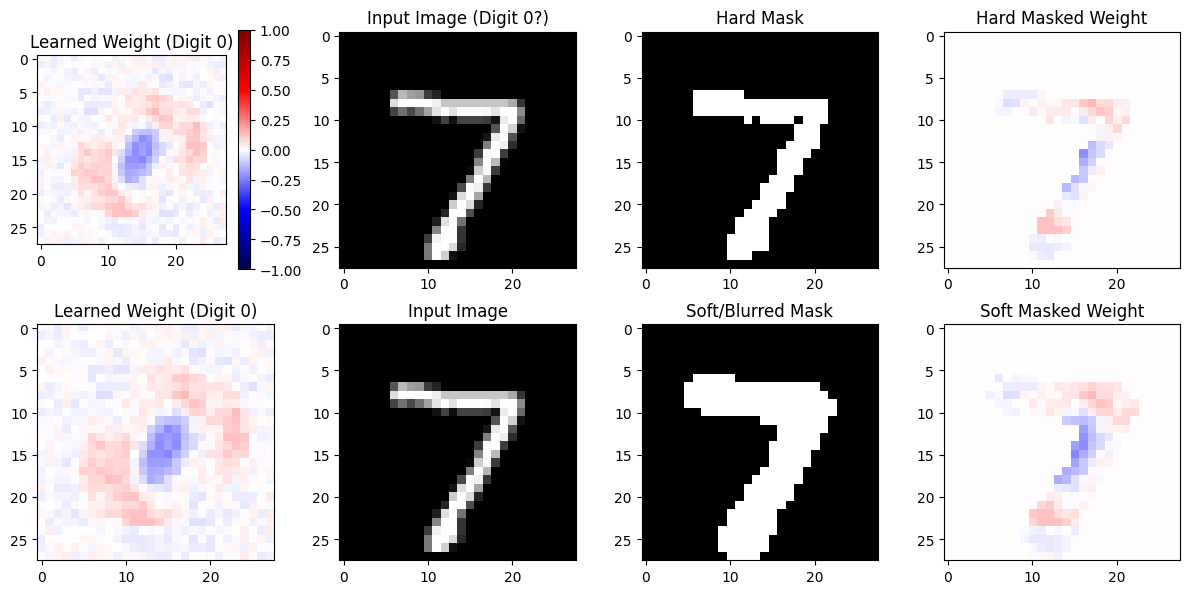

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

# Configuration
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Prepare Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1] usually helps, but MNIST is 0-1.
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# 2. Define Single Layer Network (Memristor Crossbar Simulator)
class MemristorNet(nn.Module):
    def __init__(self):
        super(MemristorNet, self).__init__()
        # 784 Inputs -> 10 Outputs (No hidden layer)
        self.fc = nn.Linear(784, 10, bias=True)

    def forward(self, x):
        x = x.view(-1, 784)
        return self.fc(x)

    def enforce_weight_constraints(self):
        # Clip weights to range [-1, 1] to simulate memristor conductance range
        with torch.no_grad():
            self.fc.weight.clamp_(-1, 1)

model = MemristorNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# 3. Train
print(f"Training on {DEVICE}...")
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Enforce Memristor Constraints
        model.enforce_weight_constraints()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

# 4. Inference Strategies
def get_accuracy(model, loader, mode='standard'):
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE) # Data shape: [Batch, 1, 28, 28]

            if mode == 'standard':
                outputs = model(data)

            elif mode == 'hard_mask':
                # Mask weights based strictly on active pixels
                # Create mask: 1 where pixel > 0.1, else 0
                masks = (data.view(-1, 784) > -0.8).float() # Threshold tuned for normalized data

                # We have to do manual matrix multiplication to apply per-sample masks
                # Output = (Input * Mask) @ Weight.T  <-- This is mathematically redundant if Input is 0.
                # The user implies masking the WEIGHTS.
                # Effective Weight for sample i = Weight * Mask_i

                weights = model.fc.weight.unsqueeze(0) # [1, 10, 784]
                inputs = data.view(-1, 784).unsqueeze(1) # [Batch, 1, 784]

                # To simulate masking the weight hardware physically:
                # We zero out weights columns where input is dark
                # Since this is linear, W_masked * X is actually identical to W * X if X is 0.
                # HOWEVER, to simulate the "noise/misalignment" challenge, we assume
                # the mask suppresses "near zero" inputs that might still have signal or noise.

                # Let's perform the element-wise masking on the weights per sample
                # [Batch, 10, 784] = [1, 10, 784] * [Batch, 1, 784] (broadcasting mask)
                masked_weights = weights * masks.unsqueeze(1)

                # Compute output: sum(Masked_Weights * Input, dim=2) + bias
                # Input must be broadcast: [Batch, 1, 784]
                outputs = (masked_weights * inputs).sum(dim=2) + model.fc.bias

            elif mode == 'soft_mask':
                # Strategy: Dilate/Blur the mask to include edges/neighbors
                # Move to CPU for scipy gaussian_filter (or implement conv2d in torch)
                inputs_np = data.cpu().numpy()
                masks_np = np.zeros_like(inputs_np)

                for i in range(inputs_np.shape[0]):
                    # Apply Gaussian Blur to create a "Soft" area of interest
                    # Sigma=1.0 spreads the mask by ~1-2 pixels
                    masks_np[i,0] = gaussian_filter(inputs_np[i,0], sigma=1.0)

                masks = torch.tensor(masks_np, device=DEVICE).view(-1, 784)
                # Create binary mask from blurred image (active region is larger now)
                masks = (masks > -0.8).float()

                weights = model.fc.weight.unsqueeze(0)
                inputs = data.view(-1, 784).unsqueeze(1)
                masked_weights = weights * masks.unsqueeze(1)
                outputs = (masked_weights * inputs).sum(dim=2) + model.fc.bias

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total

# 5. Evaluate
acc_standard = get_accuracy(model, test_loader, mode='standard')
acc_hard = get_accuracy(model, test_loader, mode='hard_mask')
acc_soft = get_accuracy(model, test_loader, mode='soft_mask')

print("-" * 30)
print(f"Standard Accuracy:   {acc_standard:.2f}%")
print(f"Hard Mask Accuracy:  {acc_hard:.2f}% (Likely lower/unstable)")
print(f"Soft Mask Accuracy:  {acc_soft:.2f}% (Proposed Strategy)")
print("-" * 30)

# 6. Visualization
def visualize_results():
    weights = model.fc.weight.data.cpu().numpy()

    # Get one sample image
    data, _ = next(iter(test_loader))
    sample_img = data[0].numpy().squeeze()

    # Generate Masks
    hard_mask = (sample_img > -0.8).astype(float)
    soft_mask = gaussian_filter(sample_img, sigma=1.0)
    soft_mask = (soft_mask > -0.8).astype(float)

    plt.figure(figsize=(12, 6))

    # Plot Weights (Digit 0)
    plt.subplot(2, 4, 1)
    plt.title("Learned Weight (Digit 0)")
    # Reshape weight to 28x28
    plt.imshow(weights[0].reshape(28, 28), cmap='seismic', vmin=-1, vmax=1)
    plt.colorbar()

    # Plot Input Image
    plt.subplot(2, 4, 2)
    plt.title("Input Image (Digit 0?)")
    plt.imshow(sample_img, cmap='gray')

    # Plot Hard Mask
    plt.subplot(2, 4, 3)
    plt.title("Hard Mask")
    plt.imshow(hard_mask, cmap='gray')

    # Plot Hard Masked Weight
    plt.subplot(2, 4, 4)
    plt.title("Hard Masked Weight")
    # Simulate masking weight[0] with the mask derived from this specific image
    plt.imshow(weights[0].reshape(28, 28) * hard_mask, cmap='seismic', vmin=-1, vmax=1)

    # Plot Weights (Digit 0) - Repeat for layout
    plt.subplot(2, 4, 5)
    plt.title("Learned Weight (Digit 0)")
    plt.imshow(weights[0].reshape(28, 28), cmap='seismic', vmin=-1, vmax=1)

    # Plot Input
    plt.subplot(2, 4, 6)
    plt.title("Input Image")
    plt.imshow(sample_img, cmap='gray')

    # Plot Soft Mask
    plt.subplot(2, 4, 7)
    plt.title("Soft/Blurred Mask")
    plt.imshow(soft_mask, cmap='gray')

    # Plot Soft Masked Weight
    plt.subplot(2, 4, 8)
    plt.title("Soft Masked Weight")
    plt.imshow(weights[0].reshape(28, 28) * soft_mask, cmap='seismic', vmin=-1, vmax=1)

    plt.tight_layout()
    plt.show()

visualize_results()

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.76MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.36MB/s]


Training on cpu...
Epoch 1/3, Loss: 0.5622
Epoch 2/3, Loss: 0.1221
Epoch 3/3, Loss: 0.3900
------------------------------
Standard Accuracy:   91.72%
Hard Mask Accuracy:  83.86%
Soft Mask Accuracy:  62.94% (Sigma=2.5)
------------------------------


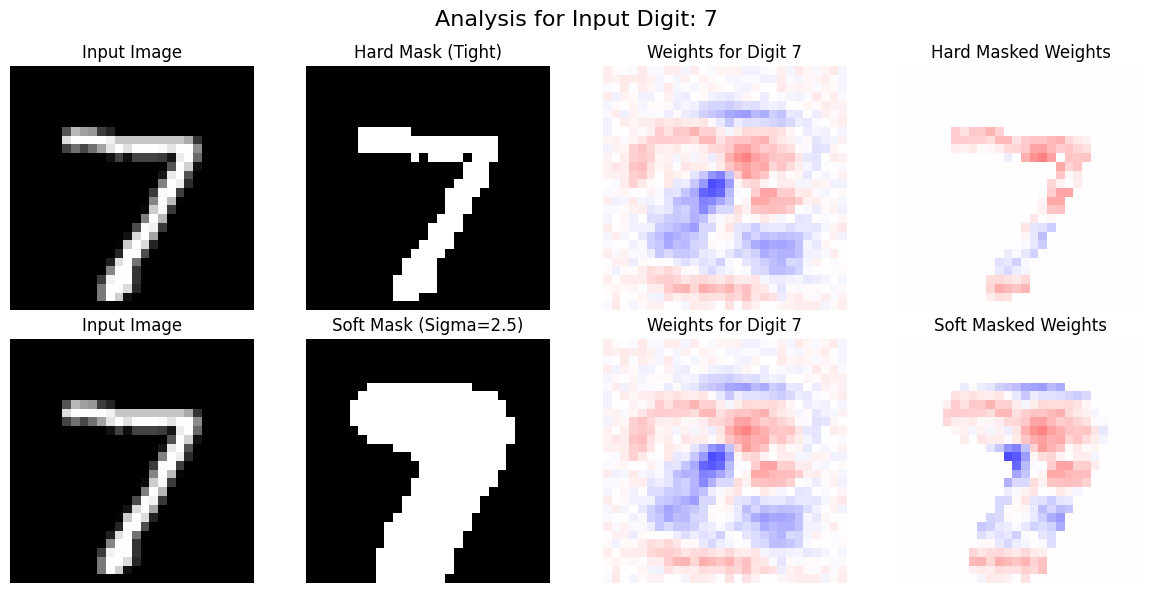

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

# Configuration
BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 0.05
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BLUR_SIGMA = 2.5  # Increased from 1.0 to 2.5 for a wider mask range

# 1. Prepare Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# 2. Define Memristor Network
class MemristorNet(nn.Module):
    def __init__(self):
        super(MemristorNet, self).__init__()
        # PyTorch Linear stores weights as [Out, In].
        # So row 'i' contains the 784 weights for digit 'i'.
        self.fc = nn.Linear(784, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 784)
        return self.fc(x)

    def enforce_weight_constraints(self):
        with torch.no_grad():
            self.fc.weight.clamp_(-1, 1)

model = MemristorNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# 3. Train
print(f"Training on {DEVICE}...")
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        model.enforce_weight_constraints()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

# 4. Inference with Strategies
def get_accuracy(model, loader, mode='standard'):
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            if mode == 'standard':
                outputs = model(data)

            elif mode == 'hard_mask':
                # Hard threshold mask
                masks = (data.view(-1, 784) > -0.8).float()
                weights = model.fc.weight.unsqueeze(0)
                inputs = data.view(-1, 784).unsqueeze(1)

                masked_weights = weights * masks.unsqueeze(1)
                outputs = (masked_weights * inputs).sum(dim=2)

            elif mode == 'soft_mask':
                # Wider Blur Strategy
                inputs_np = data.cpu().numpy()
                masks_np = np.zeros_like(inputs_np)

                for i in range(inputs_np.shape[0]):
                    # Apply wider Gaussian Blur (Sigma defined in config)
                    masks_np[i,0] = gaussian_filter(inputs_np[i,0], sigma=BLUR_SIGMA)

                masks = torch.tensor(masks_np, device=DEVICE).view(-1, 784)
                masks = (masks > -0.8).float()

                weights = model.fc.weight.unsqueeze(0)
                inputs = data.view(-1, 784).unsqueeze(1)
                masked_weights = weights * masks.unsqueeze(1)
                outputs = (masked_weights * inputs).sum(dim=2)

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total

# 5. Evaluate
print("-" * 30)
acc_standard = get_accuracy(model, test_loader, mode='standard')
print(f"Standard Accuracy:   {acc_standard:.2f}%")

acc_hard = get_accuracy(model, test_loader, mode='hard_mask')
print(f"Hard Mask Accuracy:  {acc_hard:.2f}%")

acc_soft = get_accuracy(model, test_loader, mode='soft_mask')
print(f"Soft Mask Accuracy:  {acc_soft:.2f}% (Sigma={BLUR_SIGMA})")
print("-" * 30)

# 6. Corrected Visualization
def visualize_match():
    # Fetch a batch of test data
    data_batch, target_batch = next(iter(test_loader))

    # Pick the first image in the batch
    idx = 0
    input_tensor = data_batch[idx]      # Shape: [1, 28, 28]
    true_label = target_batch[idx].item() # The actual digit (e.g., 7)

    input_img = input_tensor.numpy().squeeze()

    # Extract the SPECIFIC weight set for this digit
    # model.fc.weight is shape [10, 784]. We want the row corresponding to 'true_label'
    digit_weights = model.fc.weight.data[true_label].cpu().numpy().reshape(28, 28)

    # 1. Create Hard Mask
    hard_mask = (input_img > -0.8).astype(float)

    # 2. Create Soft Mask (Wider Blur)
    blurred_img = gaussian_filter(input_img, sigma=BLUR_SIGMA)
    soft_mask = (blurred_img > -0.8).astype(float)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Analysis for Input Digit: {true_label}", fontsize=16)

    # -- Row 1: Hard Mask (The Failure Case) --

    # Input
    plt.subplot(2, 4, 1)
    plt.title("Input Image")
    plt.imshow(input_img, cmap='gray')
    plt.axis('off')

    # Hard Mask
    plt.subplot(2, 4, 2)
    plt.title("Hard Mask (Tight)")
    plt.imshow(hard_mask, cmap='gray')
    plt.axis('off')

    # Original Weights
    plt.subplot(2, 4, 3)
    plt.title(f"Weights for Digit {true_label}")
    plt.imshow(digit_weights, cmap='seismic', vmin=-1, vmax=1)
    plt.axis('off')

    # Resulting Effective Weight
    plt.subplot(2, 4, 4)
    plt.title("Hard Masked Weights")
    plt.imshow(digit_weights * hard_mask, cmap='seismic', vmin=-1, vmax=1)
    plt.axis('off')

    # -- Row 2: Soft Mask (The Solution) --

    # Input (Repeated for alignment)
    plt.subplot(2, 4, 5)
    plt.title("Input Image")
    plt.imshow(input_img, cmap='gray')
    plt.axis('off')

    # Soft Mask
    plt.subplot(2, 4, 6)
    plt.title(f"Soft Mask (Sigma={BLUR_SIGMA})")
    plt.imshow(soft_mask, cmap='gray')
    plt.axis('off')

    # Original Weights
    plt.subplot(2, 4, 7)
    plt.title(f"Weights for Digit {true_label}")
    plt.imshow(digit_weights, cmap='seismic', vmin=-1, vmax=1)
    plt.axis('off')

    # Resulting Effective Weight
    plt.subplot(2, 4, 8)
    plt.title("Soft Masked Weights")
    plt.imshow(digit_weights * soft_mask, cmap='seismic', vmin=-1, vmax=1)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_match()

Training on cpu...
Epoch 1/3, Loss: 0.3373
Epoch 2/3, Loss: 0.2225
Epoch 3/3, Loss: 0.3646
------------------------------
Standard Accuracy:   89.93%
Hard Mask Accuracy:  83.20% (Forces unimportant weights to -1)
Soft Mask Accuracy:  62.37% (Forces unimportant weights to -1)
------------------------------


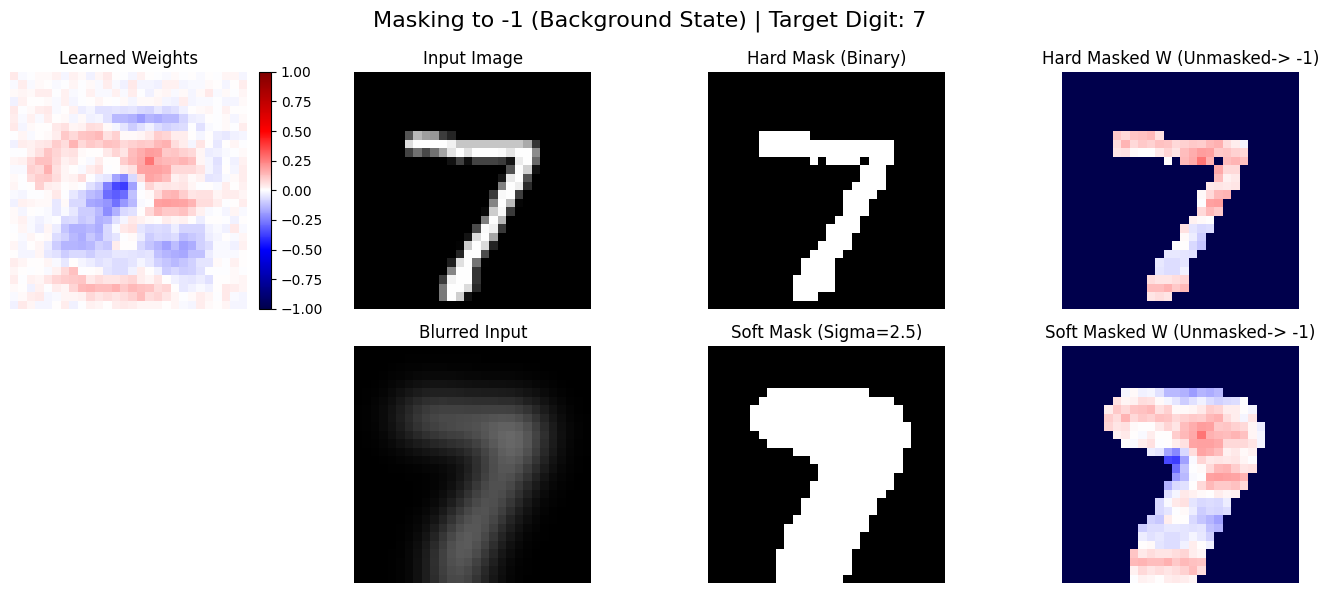

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

# Configuration
BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 0.05
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BLUR_SIGMA = 2.5 # Wide blur to preserve neighborhood info

# 1. Prepare Data (Normalized to -1 to 1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# 2. Define Memristor Network
class MemristorNet(nn.Module):
    def __init__(self):
        super(MemristorNet, self).__init__()
        self.fc = nn.Linear(784, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 784)
        return self.fc(x)

    def enforce_weight_constraints(self):
        with torch.no_grad():
            self.fc.weight.clamp_(-1, 1)

model = MemristorNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# 3. Train
print(f"Training on {DEVICE}...")
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        model.enforce_weight_constraints()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

# 4. Inference Strategies (Corrected)
def get_accuracy(model, loader, mode='standard'):
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            if mode == 'standard':
                outputs = model(data)

            else:
                # Common setup for masking
                weights = model.fc.weight.unsqueeze(0)        # [1, 10, 784]
                inputs = data.view(-1, 784).unsqueeze(1)      # [Batch, 1, 784]

                # --- GENERATE MASK ---
                if mode == 'hard_mask':
                    # Binary Mask: 1 if important, 0 if unimportant
                    masks = (data.view(-1, 784) > -0.8).float()

                elif mode == 'soft_mask':
                    # Blurred Mask
                    inputs_np = data.cpu().numpy()
                    masks_np = np.zeros_like(inputs_np)
                    for i in range(inputs_np.shape[0]):
                        masks_np[i,0] = gaussian_filter(inputs_np[i,0], sigma=BLUR_SIGMA)

                    masks = torch.tensor(masks_np, device=DEVICE).view(-1, 784)
                    masks = (masks > -0.8).float()

                # --- APPLY MASK (Force to -1 logic) ---
                # Formula: NewWeight = OldWeight * Mask + (-1) * (1 - Mask)
                # When Mask is 1: OldWeight * 1 + (-1) * 0 = OldWeight
                # When Mask is 0: OldWeight * 0 + (-1) * 1 = -1
                masks = masks.unsqueeze(1) # [Batch, 1, 784]
                masked_weights = (weights * masks) + (-1.0 * (1.0 - masks))

                # Compute Output
                outputs = (masked_weights * inputs).sum(dim=2)

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total

# 5. Evaluate
print("-" * 30)
acc_standard = get_accuracy(model, test_loader, mode='standard')
print(f"Standard Accuracy:   {acc_standard:.2f}%")

acc_hard = get_accuracy(model, test_loader, mode='hard_mask')
print(f"Hard Mask Accuracy:  {acc_hard:.2f}% (Forces unimportant weights to -1)")

acc_soft = get_accuracy(model, test_loader, mode='soft_mask')
print(f"Soft Mask Accuracy:  {acc_soft:.2f}% (Forces unimportant weights to -1)")
print("-" * 30)

# 6. Visualization (Updated with Force to -1)
def visualize_match():
    data_batch, target_batch = next(iter(test_loader))
    idx = 0
    input_tensor = data_batch[idx]
    true_label = target_batch[idx].item()
    input_img = input_tensor.numpy().squeeze()

    # Get weights for the specific true label
    digit_weights = model.fc.weight.data[true_label].cpu().numpy().reshape(28, 28)

    # 1. Hard Mask
    hard_mask = (input_img > -0.8).astype(float)
    # Apply Force to -1
    hard_masked_weights = (digit_weights * hard_mask) + (-1.0 * (1.0 - hard_mask))

    # 2. Soft Mask
    blurred_img = gaussian_filter(input_img, sigma=BLUR_SIGMA)
    soft_mask = (blurred_img > -0.8).astype(float)
    # Apply Force to -1
    soft_masked_weights = (digit_weights * soft_mask) + (-1.0 * (1.0 - soft_mask))

    plt.figure(figsize=(14, 6))
    plt.suptitle(f"Masking to -1 (Background State) | Target Digit: {true_label}", fontsize=16)

    # -- Row 1: Standard & Hard Mask --
    plt.subplot(2, 4, 1)
    plt.title("Learned Weights")
    plt.imshow(digit_weights, cmap='seismic', vmin=-1, vmax=1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')

    plt.subplot(2, 4, 2)
    plt.title("Input Image")
    plt.imshow(input_img, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')

    plt.subplot(2, 4, 3)
    plt.title("Hard Mask (Binary)")
    plt.imshow(hard_mask, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

    plt.subplot(2, 4, 4)
    plt.title("Hard Masked W (Unmasked-> -1)")
    plt.imshow(hard_masked_weights, cmap='seismic', vmin=-1, vmax=1)
    plt.axis('off')

    # -- Row 2: Soft Mask Strategy --
    plt.subplot(2, 4, 6)
    plt.title("Blurred Input")
    plt.imshow(blurred_img, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')

    plt.subplot(2, 4, 7)
    plt.title(f"Soft Mask (Sigma={BLUR_SIGMA})")
    plt.imshow(soft_mask, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

    plt.subplot(2, 4, 8)
    plt.title("Soft Masked W (Unmasked-> -1)")
    plt.imshow(soft_masked_weights, cmap='seismic', vmin=-1, vmax=1)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_match()

Training on cpu...
Epoch 1/3, Loss: 0.2077
Epoch 2/3, Loss: 0.2962
Epoch 3/3, Loss: 0.3249
------------------------------
Standard Accuracy:   90.88%
Hard Mask Accuracy:  84.48% (Forces unimportant weights to 0)
Soft Mask Accuracy:  57.56% (Forces unimportant weights to 0)
------------------------------


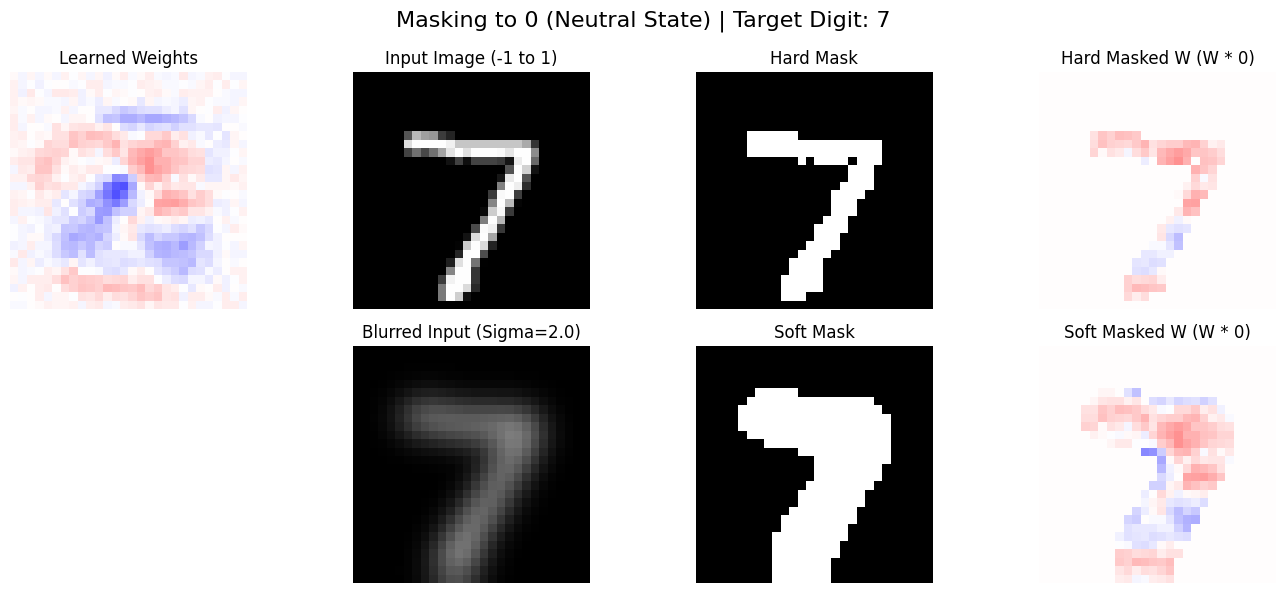

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

# Configuration
BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 0.05
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BLUR_SIGMA = 2.0  # Slightly wider blur to capture edges

# 1. Prepare Data (Normalized: Dark = -1, Bright = +1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# 2. Define Memristor Network
class MemristorNet(nn.Module):
    def __init__(self):
        super(MemristorNet, self).__init__()
        self.fc = nn.Linear(784, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 784)
        return self.fc(x)

    def enforce_weight_constraints(self):
        with torch.no_grad():
            self.fc.weight.clamp_(-1, 1)

model = MemristorNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# 3. Train
print(f"Training on {DEVICE}...")
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        model.enforce_weight_constraints()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

# 4. Inference Strategies (CORRECTED: Force to 0)
def get_accuracy(model, loader, mode='standard'):
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            if mode == 'standard':
                outputs = model(data)

            else:
                # Weights: [1, 10, 784]
                weights = model.fc.weight.unsqueeze(0)
                inputs = data.view(-1, 784).unsqueeze(1)

                # --- GENERATE MASK ---
                if mode == 'hard_mask':
                    # Dark parts (-1 to -0.8) are unimportant -> Mask 0
                    # Bright parts (> -0.8) are important -> Mask 1
                    masks = (data.view(-1, 784) > -0.8).float()

                elif mode == 'soft_mask':
                    inputs_np = data.cpu().numpy()
                    masks_np = np.zeros_like(inputs_np)
                    for i in range(inputs_np.shape[0]):
                        masks_np[i,0] = gaussian_filter(inputs_np[i,0], sigma=BLUR_SIGMA)

                    masks = torch.tensor(masks_np, device=DEVICE).view(-1, 784)
                    masks = (masks > -0.8).float()

                # --- APPLY MASK (Force to 0) ---
                masks = masks.unsqueeze(1) # [Batch, 1, 784]

                # If Mask is 0, Weight becomes 0.
                # If Mask is 1, Weight stays Weight.
                masked_weights = weights * masks

                # Compute Output
                outputs = (masked_weights * inputs).sum(dim=2)

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total

# 5. Evaluate
print("-" * 30)
acc_standard = get_accuracy(model, test_loader, mode='standard')
print(f"Standard Accuracy:   {acc_standard:.2f}%")

acc_hard = get_accuracy(model, test_loader, mode='hard_mask')
print(f"Hard Mask Accuracy:  {acc_hard:.2f}% (Forces unimportant weights to 0)")

acc_soft = get_accuracy(model, test_loader, mode='soft_mask')
print(f"Soft Mask Accuracy:  {acc_soft:.2f}% (Forces unimportant weights to 0)")
print("-" * 30)

# 6. Visualization
def visualize_match():
    data_batch, target_batch = next(iter(test_loader))
    idx = 0
    input_tensor = data_batch[idx]
    true_label = target_batch[idx].item()
    input_img = input_tensor.numpy().squeeze()

    digit_weights = model.fc.weight.data[true_label].cpu().numpy().reshape(28, 28)

    # Hard Mask
    hard_mask = (input_img > -0.8).astype(float)
    hard_masked_weights = digit_weights * hard_mask # Zeros out background

    # Soft Mask
    blurred_img = gaussian_filter(input_img, sigma=BLUR_SIGMA)
    soft_mask = (blurred_img > -0.8).astype(float)
    soft_masked_weights = digit_weights * soft_mask # Zeros out background

    plt.figure(figsize=(14, 6))
    plt.suptitle(f"Masking to 0 (Neutral State) | Target Digit: {true_label}", fontsize=16)

    # -- Row 1 --
    plt.subplot(2, 4, 1); plt.title("Learned Weights"); plt.imshow(digit_weights, cmap='seismic', vmin=-1, vmax=1); plt.axis('off')
    plt.subplot(2, 4, 2); plt.title("Input Image (-1 to 1)"); plt.imshow(input_img, cmap='gray', vmin=-1, vmax=1); plt.axis('off')
    plt.subplot(2, 4, 3); plt.title("Hard Mask"); plt.imshow(hard_mask, cmap='gray', vmin=0, vmax=1); plt.axis('off')
    plt.subplot(2, 4, 4); plt.title("Hard Masked W (W * 0)"); plt.imshow(hard_masked_weights, cmap='seismic', vmin=-1, vmax=1); plt.axis('off')

    # -- Row 2 --
    plt.subplot(2, 4, 6); plt.title(f"Blurred Input (Sigma={BLUR_SIGMA})"); plt.imshow(blurred_img, cmap='gray', vmin=-1, vmax=1); plt.axis('off')
    plt.subplot(2, 4, 7); plt.title("Soft Mask"); plt.imshow(soft_mask, cmap='gray', vmin=0, vmax=1); plt.axis('off')
    plt.subplot(2, 4, 8); plt.title("Soft Masked W (W * 0)"); plt.imshow(soft_masked_weights, cmap='seismic', vmin=-1, vmax=1); plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_match()

Training on cpu...
Epoch 1/3, Loss: 0.1551
Epoch 2/3, Loss: 0.2150
Epoch 3/3, Loss: 0.2278
------------------------------
Standard Accuracy:   91.70%
Hard Mask Accuracy:  90.93% (Binary Divisor: 1 or 256)
Soft Mask Accuracy:  91.42% (Continuous Divisor 1..256)
------------------------------


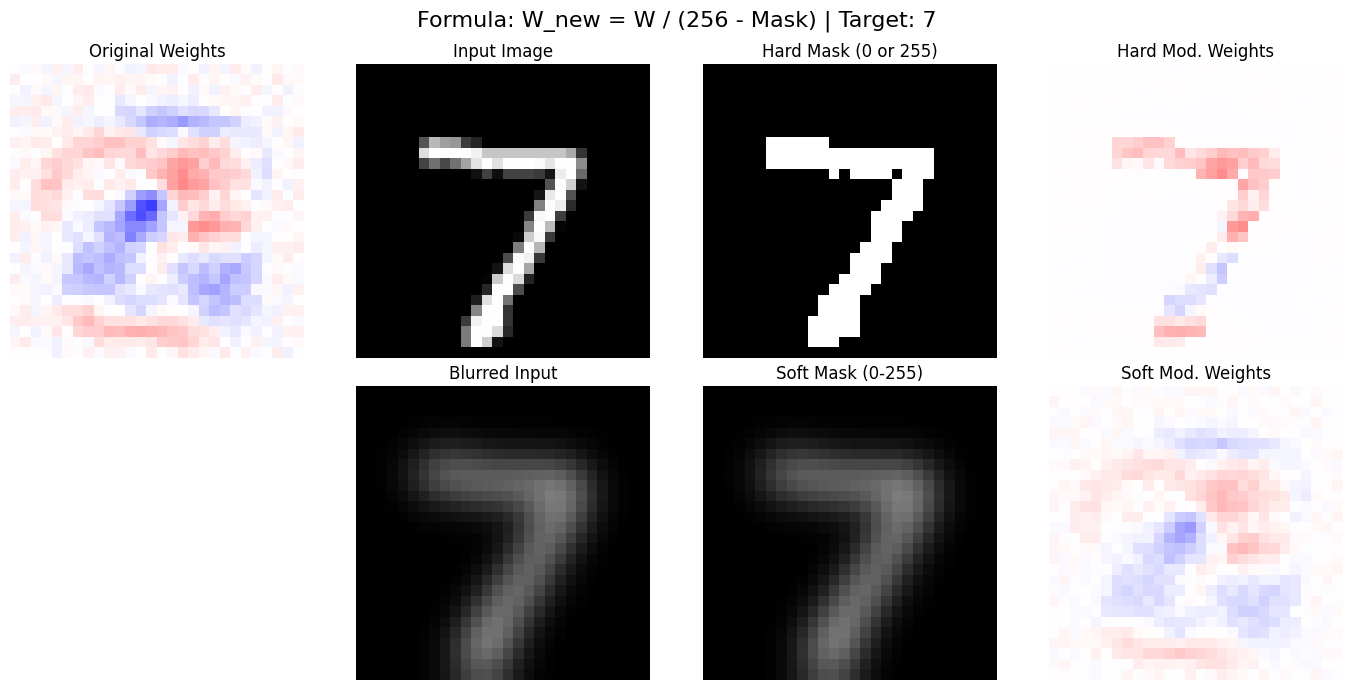

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

# Configuration
BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 0.05
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BLUR_SIGMA = 2.0

# 1. Prepare Data (Normalized: Dark = -1, Bright = +1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# 2. Define Memristor Network
class MemristorNet(nn.Module):
    def __init__(self):
        super(MemristorNet, self).__init__()
        self.fc = nn.Linear(784, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 784)
        return self.fc(x)

    def enforce_weight_constraints(self):
        with torch.no_grad():
            self.fc.weight.clamp_(-1, 1)

model = MemristorNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# 3. Train
print(f"Training on {DEVICE}...")
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        model.enforce_weight_constraints()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

# 4. Inference Strategies (UPDATED: New Formula)
def get_accuracy(model, loader, mode='standard'):
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            if mode == 'standard':
                outputs = model(data)

            else:
                # Weights: [1, 10, 784]
                weights = model.fc.weight.unsqueeze(0)
                # Inputs: [Batch, 1, 784]
                inputs = data.view(-1, 784).unsqueeze(1)

                # --- PREPARE MASK (Range 0-255) ---
                if mode == 'hard_mask':
                    # Binary: Pixel is either 0 or 255
                    # > -0.8 means strictly foreground
                    binary_mask = (data.view(-1, 784) > -0.8).float()
                    mask_vals = binary_mask * 255.0

                elif mode == 'soft_mask':
                    # Continuous: Pixel is float 0.0 to 255.0
                    inputs_np = data.cpu().numpy()
                    blurred_np = np.zeros_like(inputs_np)
                    for i in range(inputs_np.shape[0]):
                        blurred_np[i,0] = gaussian_filter(inputs_np[i,0], sigma=BLUR_SIGMA)

                    blurred_tensor = torch.tensor(blurred_np, device=DEVICE).view(-1, 784)

                    # Denormalize (-1,1) -> (0,1) -> (0, 255)
                    mask_vals = (blurred_tensor + 1.0) * 0.5 * 255.0
                    mask_vals = torch.clamp(mask_vals, 0, 255)

                # --- APPLY NEW FORMULA ---
                mask_vals = mask_vals.unsqueeze(1) # [Batch, 1, 784]

                # Formula: Weight_New = Weight_Old / (256 - Mask_Value)
                # If Mask=255 (Bright) -> Divisor=1   -> Weight Unchanged
                # If Mask=0   (Dark)   -> Divisor=256 -> Weight Scaled down by 256
                denominator = 2 - mask_vals/256
                masked_weights = weights / denominator

                # Compute Output: (Modified_W * Input).sum
                outputs = (masked_weights * inputs).sum(dim=2)

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total

# 5. Evaluate
print("-" * 30)
acc_standard = get_accuracy(model, test_loader, mode='standard')
print(f"Standard Accuracy:   {acc_standard:.2f}%")

acc_hard = get_accuracy(model, test_loader, mode='hard_mask')
print(f"Hard Mask Accuracy:  {acc_hard:.2f}% (Binary Divisor: 1 or 256)")

acc_soft = get_accuracy(model, test_loader, mode='soft_mask')
print(f"Soft Mask Accuracy:  {acc_soft:.2f}% (Continuous Divisor 1..256)")
print("-" * 30)

# 6. Visualization
def visualize_match():
    data_batch, target_batch = next(iter(test_loader))
    idx = 0
    input_tensor = data_batch[idx]
    true_label = target_batch[idx].item()
    input_img = input_tensor.numpy().squeeze()

    digit_weights = model.fc.weight.data[true_label].cpu().numpy().reshape(28, 28)

    # --- Hard Mask Processing ---
    # 1. Binary Mask (0 or 1)
    hard_bool = (input_img > -0.8).astype(float)
    # 2. Convert to Greyscale (0 or 255)
    hard_mask_grey = hard_bool * 255.0
    # 3. Apply Formula
    hard_denom = 256.0 - hard_mask_grey
    hard_masked_weights = digit_weights / hard_denom

    # --- Soft Mask Processing ---
    # 1. Blur
    blurred_img = gaussian_filter(input_img, sigma=BLUR_SIGMA)
    # 2. Convert to Greyscale (0 to 255)
    soft_mask_grey = (blurred_img + 1.0) * 0.5 * 255.0
    soft_mask_grey = np.clip(soft_mask_grey, 0, 255)
    # 3. Apply Formula
    soft_denom = 2 - soft_mask_grey/256
    soft_masked_weights = digit_weights / soft_denom

    plt.figure(figsize=(14, 7))
    plt.suptitle(f"Formula: W_new = W / (256 - Mask) | Target: {true_label}", fontsize=16)

    # -- Row 1: Hard Mask --
    plt.subplot(2, 4, 1); plt.title("Original Weights"); plt.imshow(digit_weights, cmap='seismic', vmin=-1, vmax=1); plt.axis('off')
    plt.subplot(2, 4, 2); plt.title("Input Image"); plt.imshow(input_img, cmap='gray', vmin=-1, vmax=1); plt.axis('off')
    plt.subplot(2, 4, 3); plt.title("Hard Mask (0 or 255)"); plt.imshow(hard_mask_grey, cmap='gray', vmin=0, vmax=255); plt.axis('off')
    plt.subplot(2, 4, 4); plt.title("Hard Mod. Weights"); plt.imshow(hard_masked_weights, cmap='seismic', vmin=-1, vmax=1); plt.axis('off')

    # -- Row 2: Soft Mask --
    plt.subplot(2, 4, 6); plt.title("Blurred Input"); plt.imshow(blurred_img, cmap='gray', vmin=-1, vmax=1); plt.axis('off')
    plt.subplot(2, 4, 7); plt.title("Soft Mask (0-255)"); plt.imshow(soft_mask_grey, cmap='gray', vmin=0, vmax=255); plt.axis('off')
    plt.subplot(2, 4, 8); plt.title("Soft Mod. Weights"); plt.imshow(soft_masked_weights, cmap='seismic', vmin=-1, vmax=1); plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_match()